<a href="https://colab.research.google.com/github/LuuZwide/Cartpole/blob/main/cartpole_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym[classic_control]

In [ ]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import Adam
import os
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
SEED = 3
env = gym.make('CartPole-v1',new_step_api=True)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
batch_size = 128
n_episodes = 2000
outputdir = 'CartPole_Output'
if os.path.exists(outputdir) == False :
  os.makedirs(outputdir)

In [ ]:
class Agent:
  def __init__(self,state_size,action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = deque(maxlen = 2000)
    self.gamma = 0.95
    self.epsilon = 1.0
    self.epsilon_decay = 0.995
    self.epsilon_min = 0.01
    self.tau = 0.15
    self.learning_rate = 1e-3
    self.model = self._buildModel()
    self.target_model = self._buildModel()
    self.target_model.set_weights(self.model.get_weights())
    self.memory_counter = 0

  def _buildModel(self):
    h_loss = Huber()
    adam_opt = Adam(learning_rate =self.learning_rate )

    model = Sequential()
    model.add(Dense(64, activation= 'relu',input_dim = self.state_size))
    model.add(Dense(64,activation = 'relu'))
    model.add(Dense(self.action_size))
    model.compile(loss = 'mse', optimizer = adam_opt)
    return model

  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))
    self.memory_counter += 1

  def train(self,batch_size):
    if len(self.memory) < batch_size:
      return

    minibatch = random.sample(self.memory, batch_size)
    states = []
    q_values = []
    for state, action, reward, next_state, done in minibatch:
      target_f = self.model.predict(state, verbose = 0)
      if done:
        target = -100
      else:
        target = reward + (self.gamma * np.amax(self.target_model.predict(next_state, verbose = 0)[0]))

      target_f[0][action] = target

      q_values.append(target_f)
      states.append(state)

    q_values = np.array(q_values[0])
    states = np.array(states[0])
    self.model.fit(states,q_values, verbose = 0, epochs = 1, batch_size = batch_size)

    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay

    if self.memory_counter % 40 == 0:
      self.update_weights()

  def update_weights(self):
    weights = self.model.get_weights()
    target_weights = self.target_model.get_weights()

    for i in range(len(target_weights)):
      target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)

    self.target_model.set_weights(target_weights)


  def choose_action(self,state):
    if np.random.rand() < self.epsilon:
      return random.randrange(self.action_size)
    action_values = self.model.predict(state, verbose = 0)
    action =  np.argmax(action_values[0])
    return action

  def save_weights(self,name):
    self.model.save_weights(name)

  def load_weights(self, name):
    self.model.load_weights(name)

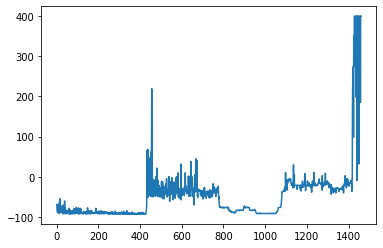

episode:  1461  score:  281.0
episode:  1462  score:  399.0
episode:  1463  score:  399.0


KeyboardInterrupt: ignored

In [ ]:
agent = Agent(state_size, action_size)
num_episodes = 1000
scores = []
for e in range(n_episodes):
  state  = env.reset(seed = SEED)
  state = np.expand_dims(state, axis = 0)
  done,trunc = (False,False)
  step = 0
  while not (done or trunc):
    action = agent.choose_action(state)
    next_state,reward, done, trunc, _ = env.step(action)
    step += reward if not (done or trunc) else -100
    next_state = np.expand_dims(next_state, axis = 0)
    agent.remember(state,action,reward,next_state,done)
    state = next_state
    if (done or trunc):
      scores.append(step)
      print('episode: ',e, ' score: ',step )

  if e % 10 == 0 or e < 10:
    clear_output(wait=True)
    plt.plot(scores)
    plt.show()

  agent.train(batch_size)

  if e % 100 == 0:
    agent.save_weights(outputdir)